<a href="https://colab.research.google.com/github/resilere/tensorflow/blob/main/C3W2_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 2 Assignment: Zombie Detection

Welcome to this week's programming assignment! You will use the Object Detection API and retrain [RetinaNet](https://arxiv.org/abs/1708.02002) to spot Zombies using just 5 training images. You will setup the model to restore pretrained weights and fine tune the classification layers.

***Important:*** *This colab notebook has read-only access so you won't be able to save your changes. If you want to save your work periodically, please click `File -> Save a Copy in Drive` to create a copy in your account, then work from there.*  

<img src='https://drive.google.com/uc?export=view&id=18Ck0qNSZy9F1KsUKWc4Jv7_x_1e_fXTN' alt='zombie'>

## Exercises

* [Exercise 1 - Import Object Detection API packages](#exercise-1)
* [Exercise 2 - Visualize the training images](#exercise-2)
* [Exercise 3 - Define the category index dictionary](#exercise-3)
* [Exercise 4 - Download checkpoints](#exercise-4)
* [Exercise 5.1 - Locate and read from the configuration file](#exercise-5-1)
* [Exercise 5.2 - Modify the model configuration](#exercise-5-2)
* [Exercise 5.3 - Modify model_config](#exercise-5-3)
* [Exercise 5.4 - Build the custom model](#exercise-5-4)
* [Exercise 6.1 - Define Checkpoints for the box predictor](#exercise-6-1)
* [Exercise 6.2 - Define the temporary model checkpoint](#exercise-6-2)
* [Exercise 6.3 - Restore the checkpoint](#exercise-6-2)
* [Exercise 7 - Run a dummy image to generate the model variables](#exercise-7)
* [Exercise 8 - Set training hyperparameters](#exercise-8)
* [Exercise 9 - Select the prediction layer variables](#exercise-9)
* [Exercise 10 - Define the training step](#exercise-10)
* [Exercise 11 - Preprocess, predict, and post process an image](#exercise-11)

## Installation

You'll start by installing the Tensorflow 2 [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection).

In [1]:
# uncomment the next line if you want to delete an existing models directory
!rm -rf ./models/

# clone the Tensorflow Model Garden
!git clone --depth 1 https://github.com/tensorflow/models/

Cloning into 'models'...
remote: Enumerating objects: 3391, done.
remote: Counting objects: 100% (3391/3391), done.
remote: Compressing objects: 100% (2815/2815), done.
remote: Total 3391 (delta 896), reused 1401 (delta 521), pack-reused 0
Receiving objects: 100% (3391/3391), 34.93 MiB | 15.92 MiB/s, done.
Resolving deltas: 100% (896/896), done.


In [2]:
# Compile the Object Detection API protocol buffers
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=.

You will write a file based on the [setup script](https://github.com/tensorflow/models/blob/master/research/object_detection/packages/tf2/setup.py) in the official repo to work with the packages in the current version of Colab. We removed some the packages that is not needed in this lab to make the installation faster.

In [3]:
%%writefile models/research/setup.py

import os
from setuptools import find_packages
from setuptools import setup

REQUIRED_PACKAGES = [
    'tf-models-official==2.8.0',
    'tensorflow_io'
]

setup(
    name='object_detection',
    version='0.1',
    install_requires=REQUIRED_PACKAGES,
    include_package_data=True,
    packages=(
        [p for p in find_packages() if p.startswith('object_detection')] +
        find_packages(where=os.path.join('.', 'slim'))),
    package_dir={
        'datasets': os.path.join('slim', 'datasets'),
        'nets': os.path.join('slim', 'nets'),
        'preprocessing': os.path.join('slim', 'preprocessing'),
        'deployment': os.path.join('slim', 'deployment'),
        'scripts': os.path.join('slim', 'scripts'),
    },
    description='Tensorflow Object Detection Library',
    python_requires='>3.6',
)

Writing models/research/setup.py


In [4]:
# Run the setup script you just wrote
!python -m pip install models/research

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 2.2 MB 24.0 MB/s 
     |████████████████████████████████| 25.9 MB 1.4 MB/s 
     |████████████████████████████████| 48.3 MB 90 kB/s 
     |████████████████████████████████| 92 kB 4.4 MB/s 
     |████████████████████████████████| 636 kB 68.7 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 99 kB 9.2 MB/s 
     |████████████████████████████████| 1.2 MB 53.6 MB/s 
     |█████████████

## Imports

Let's now import the packages you will use in this assignment.

In [5]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import zipfile
import io
import scipy.misc
import numpy as np

import glob
import imageio
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

<a name='exercise-1'></a>
### **Exercise 1**: Import Object Detection API packages

Import the necessary modules from the `object_detection` package. 
- From the [utils](https://github.com/tensorflow/models/tree/master/research/object_detection/utils) package:
  - [label_map_util](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/label_map_util.py)
  - [config_util](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/config_util.py): You'll use this to read model configurations from a .config file and then modify that configuration
  - [visualization_utils](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py): please give this the alias `viz_utils`, as this is what will be used in some visualization code that is given to you later.
  - [colab_utils](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/colab_utils.py)
- From the [builders](https://github.com/tensorflow/models/tree/master/research/object_detection/builders) package:
  - [model_builder](https://github.com/tensorflow/models/blob/master/research/object_detection/builders/model_builder.py): This builds your model according to the model configuration that you'll specify.

In [7]:
### START CODE HERE (Replace Instances of `None` with your code) ###
# import the label map utility module
from object_detection.utils import label_map_util

# import module for reading and updating configuration files.
from object_detection.utils import config_util

# import module for visualization. use the alias `viz_utils`
from object_detection.utils import visualization_utils as viz_utils

# import module for building the detection model
from object_detection.builders import model_builder
### END CODE HERE ###

# import module for utilities in Colab
from object_detection.utils import colab_utils

## Utilities

You'll define a couple of utility functions for loading images and plotting detections. This code is provided for you.

In [8]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: a file path.

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    """Wrapper function to visualize detections.

    Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
          and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
          this function assumes that the boxes to be plotted are groundtruth
          boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
          category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
    """
    
    image_np_with_annotations = image_np.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8)
    
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    
    else:
        plt.imshow(image_np_with_annotations)


## Download the Zombie data

Now you will get 5 images of zombies that you will use for training. 
- The zombies are hosted in a Google bucket.
- You can download and unzip the images into a local `training/` directory by running the cell below.

In [9]:
# uncomment the next 2 lines if you want to delete an existing zip and training directory
# !rm training-zombie.zip
# !rm -rf ./training

# download the images
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training-zombie.zip \
    -O ./training-zombie.zip

# unzip to a local directory
local_zip = './training-zombie.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./training')
zip_ref.close()

--2022-06-19 10:11:34--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training-zombie.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1915446 (1.8M) [application/zip]
Saving to: ‘./training-zombie.zip’

./training-zombie.z 100%[===================>]   1.83M  --.-KB/s    in 0.01s   

2022-06-19 10:11:34 (142 MB/s) - ‘./training-zombie.zip’ saved [1915446/1915446]



<a name='exercise-2'></a>

### **Exercise 2**: Visualize the training images

Next, you'll want to inspect the images that you just downloaded. 

* Please replace instances of `None` below to load and visualize the 5 training images. 
* You can inspect the *training* directory (using the `Files` button on the left side of this Colab) to see the filenames of the zombie images. The paths for the images will look like this:

```
./training/training-zombie1.jpg
./training/training-zombie2.jpg
./training/training-zombie3.jpg
./training/training-zombie4.jpg
./training/training-zombie5.jpg
```
- To set file paths, you'll use [os.path.join](https://www.geeksforgeeks.org/python-os-path-join-method/).  As an example, if you wanted to create the path './parent_folder/file_name1.txt', you could write: 

`os.path.join('parent_folder', 'file_name' + str(1) + '.txt')`

* You should see the 5 training images after running this cell. If not, please inspect your code, particularly the `image_path`.

training/training-zombie1.jpg
training/training-zombie2.jpg
training/training-zombie3.jpg
training/training-zombie4.jpg
training/training-zombie5.jpg


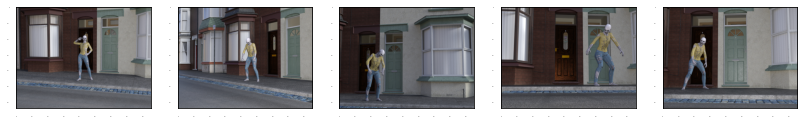

In [10]:
%matplotlib inline

### START CODE HERE (Replace Instances of `None` with your code) ###

# assign the name (string) of the directory containing the training images
train_image_dir = './training'

# declare an empty list
train_images_np = []

# run a for loop for each image
for i in range(1, 6):

    # define the path (string) for each image
    image_path = os.path.join('training','training-zombie%s.jpg'%i)
    print(image_path)

    # load images into numpy arrays and append to a list
    train_images_np.append(load_image_into_numpy_array(image_path))
### END CODE HERE ###

# configure plot settings via rcParams
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

# plot images
for idx, train_image_np in enumerate(train_images_np):
    plt.subplot(1, 5, idx+1)
    plt.imshow(train_image_np)

plt.show()

<a name='gt_boxes_definition'></a>
## Prepare data for training (Optional)

In this section, you will create your ground truth boxes. You can either draw your own boxes or use a prepopulated list of coordinates that we have provided below. 


In [11]:
# Define the list of ground truth boxes
gt_boxes = []

#### Option 1: draw your own ground truth boxes
If you want to draw your own, please run the next cell and the following test code. If not, then skip these optional cells.

* Draw a box around the zombie in each image. 
* Click the `next image` button to go to the next image
* Click `submit` when it says "All images completed!!". 

- Make sure to not make the bounding box too big. 
  - If the box is too big, the model might learn the features of the background (e.g. door, road, etc) in determining if there is a zombie or not. 
- Include the entire zombie inside the box. 
- As an example, scroll to the beginning of this notebook to look at the bounding box around the zombie.

In [12]:
# Option 1: draw your own ground truth boxes

# annotate the training images
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [13]:
# Option 1: draw your own ground truth boxes
# TEST CODE:
try:
  assert(len(gt_boxes) == 5), "Warning: gt_boxes is empty. Did you click `submit`?"

except AssertionError as e:
  print(e)

# checks if there are boxes for all 5 images
for gt_box in gt_boxes:
    try:
      assert(gt_box is not None), "There are less than 5 sets of box coordinates. " \
                                  "Please re-run the cell above to draw the boxes again.\n" \
                                  "Alternatively, you can run the next cell to load pre-determined " \
                                  "ground truth boxes."
    
    except AssertionError as e:
        print(e)
        break


ref_gt_boxes = [
        np.array([[0.27333333, 0.41500586, 0.74333333, 0.57678781]]),
        np.array([[0.29833333, 0.45955451, 0.75666667, 0.61078546]]),
        np.array([[0.40833333, 0.18288394, 0.945, 0.34818288]]),
        np.array([[0.16166667, 0.61899179, 0.8, 0.91910903]]),
        np.array([[0.28833333, 0.12543962, 0.835, 0.35052755]]),
      ]

for gt_box, ref_gt_box in zip(gt_boxes, ref_gt_boxes):
    try:
      assert(np.allclose(gt_box, ref_gt_box, atol=0.04)), "One of the boxes is too big or too small. " \
                                                          "Please re-draw and make the box tighter around the zombie."
    
    except AssertionError as e:
      print(e)
      break

<a name='gt-boxes'></a>
#### Option 2: use the given ground truth boxes
You can also use this list if you opt not to draw the boxes yourself.

In [ ]:
# Option 2: use given ground truth boxes
# set this to `True` if you want to override the boxes you drew
override = False

# bounding boxes for each of the 5 zombies found in each image. 
# you can use these instead of drawing the boxes yourself.
ref_gt_boxes = [
        np.array([[0.27333333, 0.41500586, 0.74333333, 0.57678781]]),
        np.array([[0.29833333, 0.45955451, 0.75666667, 0.61078546]]),
        np.array([[0.40833333, 0.18288394, 0.945, 0.34818288]]),
        np.array([[0.16166667, 0.61899179, 0.8, 0.91910903]]),
        np.array([[0.28833333, 0.12543962, 0.835, 0.35052755]]),
      ]

# if gt_boxes is empty, use the reference
if not gt_boxes or override is True:
  gt_boxes = ref_gt_boxes

# if gt_boxes does not contain 5 box coordinates, use the reference 
for gt_box in gt_boxes:
    try:
      assert(gt_box is not None)
    
    except:
      gt_boxes = ref_gt_boxes
      
      break


#### View your ground truth box coordinates
Whether you chose to draw your own or use the given boxes, please check your list of ground truth box coordinates.

In [14]:
# print the coordinates of your ground truth boxes
for gt_box in gt_boxes:
  print(gt_box)

[[0.27106771 0.42203986 0.73273437 0.57913247]]
[[0.30606771 0.46189918 0.75106771 0.60961313]]
[[0.40440104 0.18991794 0.93773438 0.34466589]]
[[0.15773438 0.61664713 0.78773437 0.91559203]]
[[0.27606771 0.13012896 0.82440104 0.34583822]]


Below, we add the class annotations. For simplicity, we assume just a single class, though it should be straightforward to extend this to handle multiple classes. We will also convert everything to the format that the training loop expects (e.g., conversion to tensors, one-hot representations, etc.).

<a name='exercise-3'></a>

### **Exercise 3**: Define the category index dictionary

You'll need to tell the model which integer class ID to assign to the 'zombie' category, and what 'name' to associate with that integer id.

- zombie_class_id: By convention, class ID integers start numbering from 1,2,3, onward.
  - If there is ever a 'background' class, it could be assigned the integer 0, but in this case, you're just predicting the one zombie class.
  - Since you are just predicting one class (zombie), please assign `1` to the zombie class ID.

- category_index: Please define the `category_index` dictionary, which will have the same structure as this:
```
{human_class_id : 
  {'id'  : human_class_id, 
   'name': 'human_so_far'}
}
```
  - Define `category_index` similar to the example dictionary above, except for zombies.
  - This will be used by the succeeding functions to know the class `id` and `name` of zombie images.

- num_classes: Since you are predicting one class, please assign `1` to the number of classes that the model will predict.
  - This will be used during data preprocessing and again when you configure the model.


In [15]:
### START CODE HERE (Replace instances of `None` with your code ###

# Assign the zombie class ID
zombie_class_id = 1

# define a dictionary describing the zombie class
category_index = {zombie_class_id : 
{'id'  : zombie_class_id, 
 'name': 'zombie'}
}

# Specify the number of classes that the model will predict
num_classes = 1
### END CODE HERE ###

In [16]:
# TEST CODE:

print(category_index[zombie_class_id])

{'id': 1, 'name': 'zombie'}


**Expected Output:**

```txt
{'id': 1, 'name': 'zombie'}
```

### Data preprocessing
You will now do some data preprocessing so it is formatted properly before it is fed to the model:
- Convert the class labels to one-hot representations
- convert everything (i.e. train images, gt boxes and class labels) to tensors.

This code is provided for you.

In [17]:
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.

label_id_offset = 1
train_image_tensors = []

# lists containing the one-hot encoded classes and ground truth boxes
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
    
    # convert training image to tensor, add batch dimension, and add to list
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
        train_image_np, dtype=tf.float32), axis=0))
    
    # convert numpy array to tensor, then add to list
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    
    # apply offset to to have zero-indexed ground truth classes
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(
        np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
    
    # do one-hot encoding to ground truth classes
    gt_classes_one_hot_tensors.append(tf.one_hot(
        zero_indexed_groundtruth_classes, num_classes))

print('Done prepping data.')

Done prepping data.


## Visualize the zombies with their ground truth bounding boxes

You should see the 5 training images with the bounding boxes after running the cell below. If not, please re-run the [annotation tool](#gt_boxes_definition) again or use the prepopulated `gt_boxes` array given.


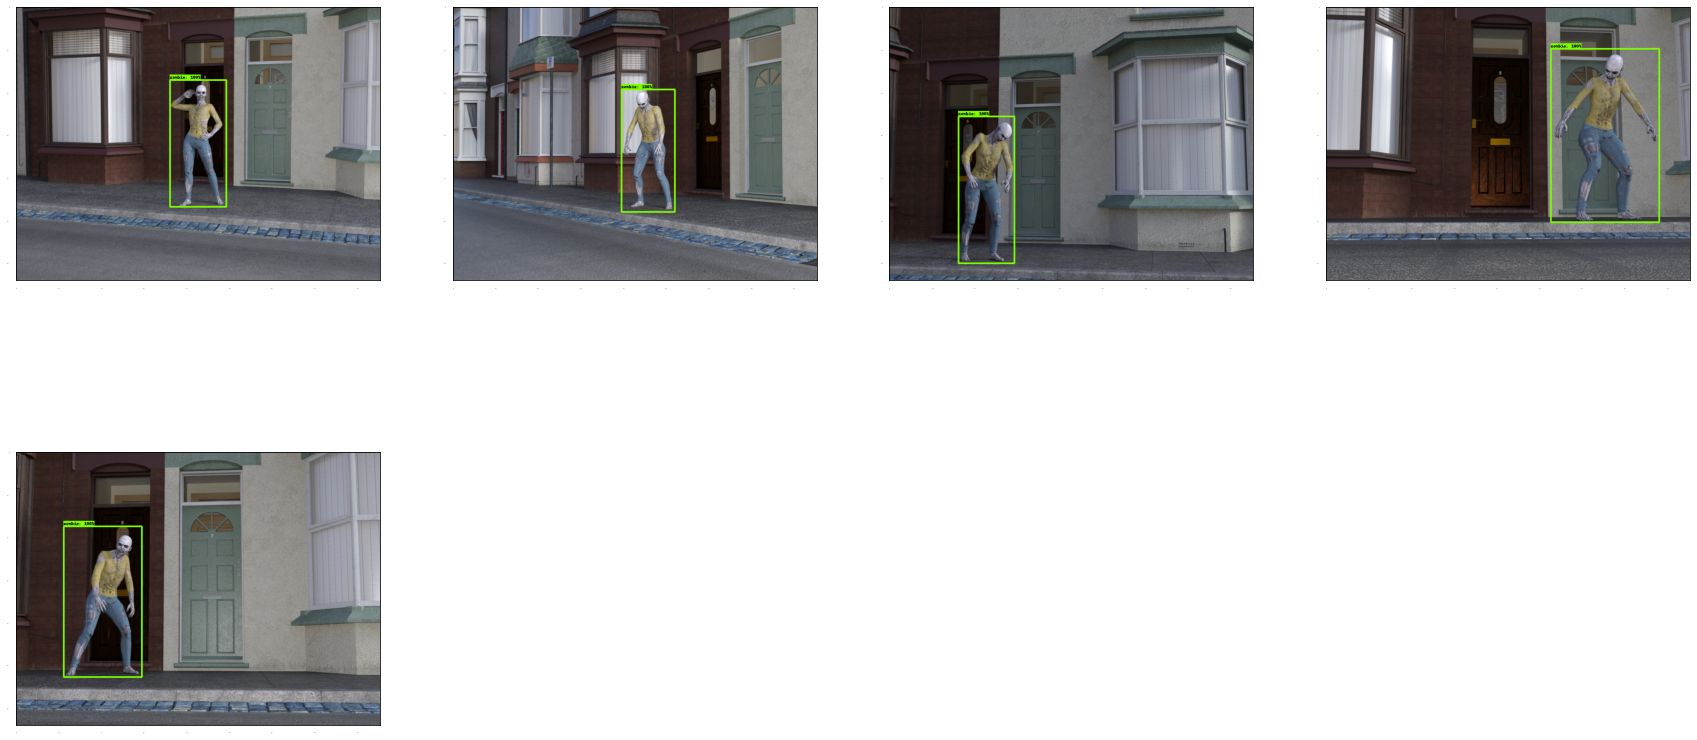

In [18]:
# give boxes a score of 100%
dummy_scores = np.array([1.0], dtype=np.float32)

# define the figure size
plt.figure(figsize=(30, 15))

# use the `plot_detections()` utility function to draw the ground truth boxes
for idx in range(5):
    plt.subplot(2, 4, idx+1)
    plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)

plt.show()

## Download the checkpoint containing the pre-trained weights

Next, you will download [RetinaNet](https://arxiv.org/abs/1708.02002) and copy it inside the object detection directory.

When working with models that are at the frontiers of research, the models and checkpoints may not yet be organized in a central location like the TensorFlow Garden (https://github.com/tensorflow/models).
- You'll often read a blog post from the researchers, who will usually provide information on:
  - how to use the model
  - where to download the models and pre-trained checkpoints.
  
It's good practice to do some of this "detective work", so that you'll feel more comfortable when exploring new models yourself!  So please try the following steps:

- Go to the [TensorFlow Blog](https://blog.tensorflow.org/), where researchers announce new findings.
- In the search box at the top of the page, search for "retinanet".
- In the search results, click on the blog post titled "TensorFlow 2 meets the Object Detection API" (it may be the first search result).
- Skim through this blog and look for links to either the checkpoints or to Colabs that will show you how to use the checkpoints.
- Try to fill out the following code cell below, which does the following:
  - Download the compressed SSD Resnet 50 version 1, 640 x 640 checkpoint.
  - Untar (decompress) the tar file
  - Move the decompressed checkpoint to `models/research/object_detection/test_data/`

If you want some help getting started, please click on the "Initial Hints" cell to get some hints.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Initial Hints</b></font>
</summary>
<p>
    
General Hints to get started
<ul>
    <li>The link to the blog is <a href="https://blog.tensorflow.org/2020/07/tensorflow-2-meets-object-detection-api.html">TensorFlow 2 meets the Object Detection API</a> </li>
    <li>In the blog, you'll find the text "COCO pre-trained weights, which links to a list of checkpoints in GitHub titled 
      <a href="https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md">TensorFlow 2 Detection Model Zoo<a>.  
    </li>
    <li>
          If you read each checkpoint name, you'll find the one for SSD Resnet 50 version 1, 640 by 640.  If you hover your mouse over
    </li>
    <li>
        If you right-click on the desired checkpoint link, you can save the link address, and use it in the code cell below to get the checkpoint.
    </li>
    <li>For more hints, please click on the cell "More Hints"</li>
</ul>
</p>


<details>    
<summary>
    <font size="3" color="darkgreen"><b>More Hints</b></font>
</summary>
<p>
    
More Hints
<ul>
    <li> To see how to download the checkpoint, look in the blog for links to Colab tutorials.
    </li>
    <li>
        For example, the blog links to a Colab titled <a href="https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/inference_tf2_colab.ipynb">Intro to Object Detection Colab</a>
    </li>
    <li>
        In the Colab, you'll see the section titled "Build a detection model and load pre-trained model weights", which is followed by a code cell showing how to download, decompress, and relocate a checkpoint.  Use similar syntax, except use the URL to the ssd resnet50 version 1 640x640 checkpoint instead.
    </li>
    <li> If you're feeling stuck, please click on the cell "Even More Hints".
    </li>
</ul>
</p>


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Even More Hints</b></font>
</summary>
<p>
    
Even More Hints
<ul>
    <li> The blog post also links to a notebook titled 
    <a href="https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb">
    Eager Few Shot Object Detection Colab</a>
    </li>
    <li> In this notebook, look for the section titled "Create model and restore weights for all but last layer".  
    The code cell below it shows how to download the exact checkpoint that you're interested in.
    </li>
    <li>You can also review the lecture videos for this week, which show the same code.</li>

</ul>
</p>


<a name='exercise-4'></a>
### Exercise 4: Download checkpoints

  - Download the compressed SSD Resnet 50 version 1, 640 x 640 checkpoint.
  - Untar (decompress) the tar file
  - Move the decompressed checkpoint to `models/research/object_detection/test_data/`


In [19]:

### START CODE HERE ###
# Download the SSD Resnet 50 version 1, 640x640 checkpoint

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

    
# untar (decompress) the tar file
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz


# copy the checkpoint to the test_data folder models/research/object_detection/test_data/
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

### END CODE HERE

--2022-06-19 11:06:17--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.68.128, 2404:6800:4003:c04::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.68.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M  58.8MB/s    in 4.0s    

2022-06-19 11:06:21 (58.8 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



## Configure the model
Here, you will configure the model for this use case.

<a name='exercise-5-1'></a>

### **Exercise 5.1**: Locate and read from the configuration file

#### pipeline_config
- In the Colab, on the left side table of contents, click on the folder icon to display the file browser for the current workspace.  
- Navigate to `models/research/object_detection/configs/tf2`.  The folder has multiple .config files.  
- Look for the file corresponding to ssd resnet 50 version 1 640x640.
- You can double-click the config file to view its contents. This may help you as you complete the next few code cells to configure your model.
- Set the `pipeline_config` to a string that contains the full path to the resnet config file, in other words: `models/research/.../... .config`


#### configs
If you look at the module [config_util](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/config_util.py) that you imported, it contains the following function:

```
def get_configs_from_pipeline_file(pipeline_config_path, config_override=None):
```
- Please use this function to load the configuration from your `pipeline_config`.
  - `configs` will now contain a dictionary.


In [23]:
tf.keras.backend.clear_session()


### START CODE HERE ###
# define the path to the .config file for ssd resnet 50 v1 640x640
pipeline_config = "/content/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config"

# Load the configuration file into a dictionary
configs = config_util.get_configs_from_pipeline_file(pipeline_config,config_override=None)

### END CODE HERE ###
# See what configs looks like
configs

{'eval_config': metrics_set: "coco_detection_metrics"
 use_moving_averages: false,
 'eval_input_config': label_map_path: "PATH_TO_BE_CONFIGURED/label_map.txt"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED/val2017-?????-of-00032.tfrecord"
 },
 'eval_input_configs': [label_map_path: "PATH_TO_BE_CONFIGURED/label_map.txt"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED/val2017-?????-of-00032.tfrecord"
 }
 ],
 'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 640
       width: 640
     }
   }
   feature_extractor {
     type: "ssd_resnet50_v1_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 0.00039999998989515007
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.029999999329447746
   

<a name='exercise-5-2'></a>

### **Exercise 5.2**: Get the model configuration

#### model_config
- From the `configs` dictionary, access the object associated with the key 'model'.
- `model_config` now contains an object of type `object_detection.protos.model_pb2.DetectionModel`.  
- If you print `model_config`, you'll see something like this:
  
```
ssd {
  num_classes: 90
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
...
...
  freeze_batchnorm: false
```

In [24]:
### START CODE HERE ###
# Read in the object stored at the key 'model' of the configs dictionary
model_config = configs['model']

### END CODE HERE
# see what model_config looks like
model_config

ssd {
  num_classes: 90
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: f

<a name='exercise-5-3'></a>

### **Exercise 5.3**: Modify model_config
- Modify num_classes from the default `90` to the `num_classes` that you set earlier in this notebook.
  - num_classes is nested under ssd.  You'll need to use dot notation 'obj.x' and NOT bracket notation obj['x']` to access num_classes.
- Freeze batch normalization 
  - Batch normalization is not frozen in the default configuration.
  - If you inspect the `model_config` object, you'll see that `freeze_batchnorm` is nested under `ssd` just like `num_classes`.
  - Freeze batch normalization by setting the relevant field to `True`.

In [25]:
### START CODE HERE ###
# Modify the number of classes from its default of 90
model_config.ssd.num_classes = num_classes

# Freeze batch normalization
model_config.ssd.freeze_batchnorm = True

### END CODE HERE

# See what model_config now looks like after you've customized it!
model_config

ssd {
  num_classes: 1
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: fa

## Build the model

Recall that you imported [model_builder](https://github.com/tensorflow/models/blob/master/research/object_detection/builders/model_builder.py).  
- You'll use `model_builder` to build the model according to the configurations that you have just downloaded and customized.

<a name='exercise-5.4'></a>

### **Exercise 5.4**: Build the custom model

#### model_builder
model_builder has a function `build`:

```
def build(model_config, is_training, add_summaries=True):

```
- model_config: Set this to the model configuration that you just customized.
- is_training: Set this to True.
- You can keep the default value for the remaining parameter.
- Note that it will take some time to build the model.

In [75]:
### START CODE HERE (Replace instances of `None` with your code) ###
detection_model = model_builder.build(model_config,is_training = True)
### END CODE HERE ###

print(type(detection_model))

<class 'object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch'>


**Expected Output**:

```txt
<class 'object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch'>
```

## Restore weights from your checkpoint

Now, you will selectively restore weights from your checkpoint.
- Your end goal is to create a custom model which reuses parts of, but not all of the layers of RetinaNet (currently stored in the variable `detection_model`.)
  - The parts of RetinaNet that you want to reuse are:
    - Feature extraction layers
    - Bounding box regression prediction layer
  - The part of RetinaNet that you will not want to reuse is the classification prediction layer (since you will define and train your own classification layer specific to zombies).
  - For the parts of RetinaNet that you want to reuse, you will also restore the weights from the checkpoint that you selected.

#### Inspect the detection_model
First, take a look at the type of the detection_model and its Python class.

In [76]:
# Run this to check the type of detection_model
detection_model

#### Find the source code for detection_model

You'll see that the type of the model is `object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch`.
Please practice some detective work and open up the source code for this class in GitHub repository.  Recall that at the start of this assignment, you cloned from this repository:  [TensorFlow Models](https://github.com/tensorflow/models).
- Navigate through these subfolders: models -> research -> object_detection.
  - If you get stuck, go to this link: [object_detection](https://github.com/tensorflow/models/tree/master/research/object_detection)
- Take a look at this 'object_detection' folder and look for the remaining folders to navigate based on the class type of detection_model: object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch
  - Hopefully you'll find the meta_architectures folder, and within it you'll notice a file named `ssd_meta_arch.py`.
  - Please open and view this [ssd_meta_arch.py](https://github.com/tensorflow/models/blob/master/research/object_detection/meta_architectures/ssd_meta_arch.py) file.

#### View the variables in detection_model
Now, check the class variables that are in `detection_model`.

In [77]:
vars(detection_model)

{'_activity_regularizer': None,
 '_add_background_class': True,
 '_add_summaries': True,
 '_anchor_generator': <object_detection.anchor_generators.multiscale_grid_anchor_generator.MultiscaleGridAnchorGenerator at 0x7f4650dd3110>,
 '_anchors': None,
 '_auto_track_sub_layers': True,
 '_autocast': True,
 '_batched_prediction_tensor_names': ListWrapper([]),
 '_box_coder': <object_detection.box_coders.faster_rcnn_box_coder.FasterRcnnBoxCoder at 0x7f45ef5a68d0>,
 '_box_predictor': <object_detection.predictors.convolutional_keras_box_predictor.WeightSharedConvolutionalBoxPredictor at 0x7f4651400a90>,
 '_build_input_shape': None,
 '_callable_losses': [],
 '_classification_loss': <object_detection.core.losses.SigmoidFocalClassificationLoss at 0x7f465165de50>,
 '_classification_loss_weight': 1.0,
 '_compute_dtype_object': tf.float32,
 '_default_training_arg': None,
 '_dtype_policy': <Policy "float32">,
 '_dynamic': False,
 '_equalization_loss_config': EqualizationLossConfig(weight=0.0, exclude_p

You'll see that detection_model contains several variables:

Two of these will be relevant to you:
```
...
_box_predictor': <object_detection.predictors.convolutional_keras_box_predictor.WeightSharedConvolutionalBoxPredictor at 0x7f5205eeb1d0>,
...
_feature_extractor': <object_detection.models.ssd_resnet_v1_fpn_keras_feature_extractor.SSDResNet50V1FpnKerasFeatureExtractor at 0x7f52040f1ef0>,
```

#### Inspect `_feature_extractor`

Take a look at the [ssd_meta_arch.py](https://github.com/tensorflow/models/blob/master/research/object_detection/meta_architectures/ssd_meta_arch.py) code.
```
# Line 302
feature_extractor: a SSDFeatureExtractor object.
```
Also
```
# Line 380
self._feature_extractor = feature_extractor
```
So `detection_model._feature_extractor` is a feature extractor, which you will want to reuse for your zombie detector model.

#### Inspect `_box_predictor`

- View the [ssd_meta_arch.py](https://github.com/tensorflow/models/blob/master/research/object_detection/meta_architectures/ssd_meta_arch.py) file (which is the source code for detection_model)
- Notice that in the __init__ constructor for class SSDMetaArch(model.DetectionModel), 
```
...
box_predictor: a box_predictor.BoxPredictor object
...
self._box_predictor = box_predictor
```
#### Inspect _box_predictor
Please take a look at the class type of `detection_model._box_predictor`

In [78]:
# view the type of _box_predictor
detection_model._box_predictor

You'll see that the class type of _box_predictor is
```
object_detection.predictors.convolutional_keras_box_predictor.WeightSharedConvolutionalBoxPredictor
```
You can navigate through the GitHub repository to this path:
- [objection_detection/predictors](https://github.com/tensorflow/models/tree/master/research/object_detection/predictors)
- Notice that there is a file named convolutional_keras_box_predictor.py.  Please open that file.

#### View variables in `_box_predictor`
Also view the variables contained in _box_predictor:

In [79]:
vars(detection_model._box_predictor)

{'_activity_regularizer': None,
 '_additional_projection_layers': ListWrapper([]),
 '_apply_batch_norm': True,
 '_apply_conv_hyperparams_pointwise': False,
 '_auto_track_sub_layers': True,
 '_autocast': True,
 '_base_tower_layers_for_heads': DictWrapper({'box_encodings': ListWrapper([]), 'class_predictions_with_background': ListWrapper([])}),
 '_box_prediction_head': <object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead at 0x7f4650dd3dd0>,
 '_build_input_shape': None,
 '_callable_losses': [],
 '_compute_dtype_object': tf.float32,
 '_conv_hyperparams': <object_detection.builders.hyperparams_builder.KerasLayerHyperparams at 0x7f4650dd3690>,
 '_default_training_arg': None,
 '_depth': 256,
 '_dtype_policy': <Policy "float32">,
 '_dynamic': False,
 '_expects_mask_arg': True,
 '_expects_training_arg': True,
 '_freeze_batchnorm': True,
 '_head_scope_conv_layers': DictWrapper({}),
 '_inbound_nodes_value': [],
 '_initial_weights': None,
 '_inplace_batchnorm_update':

Among the variables listed, a few will be relevant to you:

```
...
_base_tower_layers_for_heads
...
_box_prediction_head
...
_prediction_heads
```

In the source code for [convolutional_keras_box_predictor.py](https://github.com/tensorflow/models/blob/master/research/object_detection/predictors/convolutional_keras_box_predictor.py) that you just opened, look at the source code to get a sense for what these three variables represent.

#### Inspect `base_tower_layers_for_heads`
If you look at the [convolutional_keras_box_predictor.py](https://github.com/tensorflow/models/blob/master/research/object_detection/predictors/convolutional_keras_box_predictor.py) file, you'll notice this:
```
# line 302
self._base_tower_layers_for_heads = {
        BOX_ENCODINGS: [],
        CLASS_PREDICTIONS_WITH_BACKGROUND: [],
    }
```
- `base_tower_layers_for_heads` is a dictionary with two key-value pairs.
  - `BOX_ENCODINGS`: points to a list of layers
  - `CLASS_PREDICTIONS_WITH_BACKGROUND`: points to a list of layers
  - If you scan the code, you'll see that for both of these, the lists are filled with all layers that appear BEFORE the prediction layer.
```
# Line 377
# Stack the base_tower_layers in the order of conv_layer, batch_norm_layer
    # and activation_layer
    base_tower_layers = []
    for i in range(self._num_layers_before_predictor):
```

So `detection_model.box_predictor._base_tower_layers_for_heads` contains:
- The layers for the prediction before the final bounding box prediction
- The layers for the prediction before the final class prediction.

You will want to use these in your model.



#### Inspect `_box_prediction_head`
If you again look at [convolutional_keras_box_predictor.py](https://github.com/tensorflow/models/blob/master/research/object_detection/predictors/convolutional_keras_box_predictor.py) file, you'll see this

```
# Line 248
box_prediction_head: The head that predicts the boxes.
```
So `detection_model.box_predictor._box_prediction_head` points to the bounding box prediction layer, which you'll want to use for your model.

#### Inspect `_prediction_heads`

If you again look at [convolutional_keras_box_predictor.py](https://github.com/tensorflow/models/blob/master/research/object_detection/predictors/convolutional_keras_box_predictor.py) file, you'll see this
```
# Line 121
self._prediction_heads = {
        BOX_ENCODINGS: box_prediction_heads,
        CLASS_PREDICTIONS_WITH_BACKGROUND: class_prediction_heads,
    }
```
You'll also see this docstring
```
# Line 83
class_prediction_heads: A list of heads that predict the classes.
```

So `detection_model.box_predictor._prediction_heads` is a dictionary that points to both prediction layers:
- The layer that predicts the bounding boxes
- The layer that predicts the class (category).

#### Which layers will you reuse?
Remember that you are reusing the model for its feature extraction and bounding box detection.
- You will create your own classification layer and train it on zombie images.
- So you won't need to reuse the class prediction layer of `detection_model`.

## Define checkpoints for desired layers
You will now isolate the layers of `detection_model` that you wish to reuse so that you can restore the weights to just those layers.
- First, define checkpoints for the box predictor
- Next, define checkpoints for the model, which will point to this box predictor checkpoint as well as the feature extraction layers.

Please use [tf.train.Checkpoint](https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint).

As a reminder of how to use tf.train.Checkpoint:

```
tf.train.Checkpoint(
    **kwargs
)
```
Pretend that `detection_model` contains these variables for which you want to restore weights:
- `detection_model._ice_cream_sundae`
- 'detection_model._pies._apple_pie`
- 'detection_model._pies._pecan_pie`

Notice that the pies are nested within `._pies`.

If you just want the ice cream sundae and apple pie variables (and not the pecan pie) then you can do the following:

```
tmp_pies_checkpoint = tf.train.Checkpoint(
  _apple_pie = detection_model._pies._apple_pie
)
```

Next, in order to connect these together in a node graph, do this:
```
tmp_model_checkpoint = tf.train.Checkpoint(
  _pies = tmp_pies_checkpoint,
  _ice_cream_sundae = detection_model._ice_cream_sundae
)
```

Finally, define a checkpoint that uses the key `model` and takes in the tmp_model_checkpoint.

```
checkpoint = tf.train.Checkpoint(
  model = tmp_model_checkpoint
)
```

You'll then be ready to restore the weights from the checkpoint that you downloaded.

Try this out step by step!



<a name='exercise-6-1'></a>
### Exercise 6.1: Define Checkpoints for the box predictor

- Please define `box_predictor_checkpoint` to be checkpoint for these two layers of the `detection_model`'s box predictor:
  - The base tower layer (the layers the precede both the class prediction and bounding box prediction layers).
  - The box prediction head (the prediction layer for bounding boxes).
- Note, you won't include the class prediction layer.

In [80]:
### START CODE HERE ###

tmp_box_predictor_checkpoint = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )


### END CODE HERE

In [81]:
# Check the datatype of this checkpoint
type(tmp_box_predictor_checkpoint)

# Expected output:
# tensorflow.python.training.tracking.util.Checkpoint

tensorflow.python.training.tracking.util.Checkpoint

In [82]:
# Check the variables of this checkpoint
vars(tmp_box_predictor_checkpoint)

{'_attached_dependencies': None,
 '_base_tower_layers_for_heads': DictWrapper({'box_encodings': ListWrapper([]), 'class_predictions_with_background': ListWrapper([])}),
 '_box_prediction_head': <object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead at 0x7f4650dd3dd0>,
 '_save_assign_op': None,
 '_save_counter': None,
 '_saver': <tensorflow.python.training.tracking.util.TrackableSaver at 0x7f4650dc0c50>,
 '_self_name_based_restores': set(),
 '_self_saveable_object_factories': {},
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [TrackableReference(name=_base_tower_layers_for_heads, ref={'box_encodings': ListWrapper([]), 'class_predictions_with_background': ListWrapper([])}),
  TrackableReference(name=_box_prediction_head, ref=<object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead object at 0x7f4650dd3dd0>)],
 '_self_unconditional_deferred_dependencies': {},
 '_self_unconditional_dependency_names': {'

#### Expected output
You should expect to see a list of variables that include the following:
```
'_base_tower_layers_for_heads': DictWrapper({'box_encodings': ListWrapper([]), 'class_predictions_with_background': ListWrapper([])}),
'_box_prediction_head': <object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead at 0x7fefac014710>,
 ... 
```

<a name='exercise-6-2'></a>
### Exercise 6.2: Define the temporary model checkpoint**

Now define `tmp_model_checkpoint` so that it points to these two layers:
- The feature extractor of the detection model.
- The temporary box predictor checkpoint that you just defined.


In [83]:
### START CODE HERE ###

tmp_model_checkpoint = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=tmp_box_predictor_checkpoint)
          
             

### END CODE HERE ###

In [84]:
# Check the datatype of this checkpoint
type(tmp_model_checkpoint)

# Expected output
# tensorflow.python.training.tracking.util.Checkpoint

tensorflow.python.training.tracking.util.Checkpoint

In [85]:
# Check the vars of this checkpoint
vars(tmp_model_checkpoint)

{'_attached_dependencies': None,
 '_box_predictor': <tensorflow.python.training.tracking.util.Checkpoint at 0x7f4650dc0e50>,
 '_feature_extractor': <object_detection.models.ssd_resnet_v1_fpn_keras_feature_extractor.SSDResNet50V1FpnKerasFeatureExtractor at 0x7f4650dd3090>,
 '_save_assign_op': None,
 '_save_counter': None,
 '_saver': <tensorflow.python.training.tracking.util.TrackableSaver at 0x7f46507f0e90>,
 '_self_name_based_restores': set(),
 '_self_saveable_object_factories': {},
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [TrackableReference(name=_box_predictor, ref=<tensorflow.python.training.tracking.util.Checkpoint object at 0x7f4650dc0e50>),
  TrackableReference(name=_feature_extractor, ref=<object_detection.models.ssd_resnet_v1_fpn_keras_feature_extractor.SSDResNet50V1FpnKerasFeatureExtractor object at 0x7f4650dd3090>)],
 '_self_unconditional_deferred_dependencies': {},
 '_self_unconditional_dependency_names': {'_box_predictor': <tensorflow

#### Expected output
Among the variables of this checkpoint, you should see:
```
'_box_predictor': <tensorflow.python.training.tracking.util.Checkpoint at 0x7fefac044a20>,
 '_feature_extractor': <object_detection.models.ssd_resnet_v1_fpn_keras_feature_extractor.SSDResNet50V1FpnKerasFeatureExtractor at 0x7fefac0240b8>,
```

<a name='exercise-6-3'></a>
### Exercise 6.3: Restore the checkpoint

You can now restore the checkpoint.

First, find and set the `checkpoint_path`

- checkpoint_path: 
  - Using the "files" browser in the left side of Colab, navigate to `models -> research -> object_detection -> test_data`. 
  - If you completed the previous code cell that downloads and moves the checkpoint, you'll see a subfolder named "checkpoint".  
    - The 'checkpoint' folder contains three files:
      - checkpoint
      - ckpt-0.data-00000-of-00001
      - ckpt-0.index
    - Please set checkpoint_path to the path to the full path `models/.../ckpt-0` 
      - Notice that you don't want to include a file extension after `ckpt-0`.
    - **IMPORTANT**: Please don't set the path to include the `.index` extension in the checkpoint file name.  
      - If you do set it to `ckpt-0.index`, there won't be any immediate error message, but later during training, you'll notice that your model's loss doesn't improve, which means that the pre-trained weights were not restored properly.

Next, define one last checkpoint using `tf.train.Checkpoint()`.
- For the single keyword argument, 
  - Set the key as `model=` 
  - Set the value to your temporary model checkpoint that you just defined.
- **IMPORTANT**: You'll need to set the keyword argument as `model=` and not something else like `detection_model=`.
- If you set this keyword argument to anything else, it won't show an immmediate error, but when you train your model on the zombie images, your model loss will not decrease (your model will not learn).

Finally, call this checkpoint's `.restore()` function, passing in the path to the checkpoint.

In [86]:
### START CODE HERE ###

checkpoint_path = "/content/models/research/object_detection/test_data/checkpoint/ckpt-0"

# Define a checkpoint that sets `model= None
checkpoint = tf.train.Checkpoint(model=tmp_model_checkpoint)

# Restore the checkpoint to the checkpoint path
checkpoint.restore(checkpoint_path)

### END CODE HERE ###

<a name='exercise-7'></a>
### **Exercise 7**: Run a dummy image to generate the model variables

Run a dummy image through the model so that variables are created. We need to select the trainable variables later in Exercise 9 and right now, it is still empty. Try running `len(detection_model.trainable_variables)` in a code cell and you will get `0`. We will pass in a dummy image through the forward pass to create these variables.

Recall that `detection_model` is an object of type [object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch]() 

Important methods that are available in the `detection_model` object  are:
- [preprocess()](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L459): 
    - takes in a tensor representing an image and returns
    - returns `image, shapes`
    - For the dummy image, you can declare a [tensor of zeros](https://www.tensorflow.org/api_docs/python/tf/zeros) that has a shape that the `preprocess()` method can accept (i.e. [batch, height, width, channels]). 
    - Remember that your images have dimensions 640 x 640 x 3. 
    - You can pass in a batch of 1 when making the dummy image. 

- [predict()](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L525)
  - takes in `image, shapes` which are created by the `preprocess()` function call.
  - returns a prediction in a Python dictionary
  - this will pass the dummy image through the forward pass of the network and create the model variables

- [postprocess()](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L655)
  - Takes in the prediction_dict and shapes
  - returns a dictionary of post-processed predictions of detected objects ("detections").
  
  
**Note**: Please use the recommended variable names, which include the prefix `tmp_`, since these variables won't be used later, but you'll define similarly-named variables later for predicting on actual zombie images. 

In [87]:
### START CODE HERE (Replace instances of `None` with your code)###

# use the detection model's `preprocess()` method and pass a dummy image
tmp_image, tmp_shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))

# run a prediction with the preprocessed image and shapes
tmp_prediction_dict = detection_model.predict(tmp_image, tmp_shapes)

# postprocess the predictions into final detections
tmp_detections = detection_model.postprocess(tmp_prediction_dict, tmp_shapes)

### END CODE HERE ###

print('Weights restored!')

Weights restored!


In [88]:
# Test Code:
assert len(detection_model.trainable_variables) > 0, "Please pass in a dummy image to create the trainable variables."

print(detection_model.weights[0].shape)
print(detection_model.weights[231].shape)
print(detection_model.weights[462].shape)

(3, 3, 256, 24)
(512,)
(256,)


**Expected Output**:

```txt
(3, 3, 256, 24)
(512,)
(256,)
```

## Eager mode custom training loop

With the data and model now setup, you can now proceed to configure the training.


<a name='exercise-8'></a>
### **Exercise 8**: Set training hyperparameters

Set an appropriate learning rate and optimizer for the training. 

- batch_size: you can use 4
  - You can increase the batch size up to 5, since you have just 5 images for training.
- num_batches: You can use 100
  - You can increase the number of batches but the training will take longer to complete. 
- learning_rate: You can use 0.01
  - When you run the training loop later, notice how the initial loss INCREASES` before decreasing. 
  - You can try a lower learning rate to see if you can avoid this increased loss.
- optimizer: you can use [tf.keras.optimizers.SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD)
  - Set the learning rate
  - Set the momentum to 0.9
  
Training will be fairly quick, so we do encourage you to experiment a bit with these hyperparameters!

In [89]:
tf.keras.backend.set_learning_phase(True)

### START CODE HERE (Replace instances of `None` with your code)###

# set the batch_size
batch_size = 5

# set the number of batches
num_batches = 100

# Set the learning rate
learning_rate = 0.01

# set the optimizer and pass in the learning_rate
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

### END CODE HERE ###

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


## Choose the layers to fine-tune

To make use of transfer learning and pre-trained weights, you will train just certain parts of the detection model, namely, the last prediction layers.
- Please take a minute to inspect the layers of `detection_model`.

In [90]:
# Inspect the layers of detection_model
for i,v in enumerate(detection_model.trainable_variables):
    print(f"i: {i} \t name: {v.name} \t shape:{v.shape} \t dtype={v.dtype}")

i: 0 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0 	 shape:(3, 3, 256, 24) 	 dtype=<dtype: 'float32'>
i: 1 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/bias:0 	 shape:(24,) 	 dtype=<dtype: 'float32'>
i: 2 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0 	 shape:(3, 3, 256, 12) 	 dtype=<dtype: 'float32'>
i: 3 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/bias:0 	 shape:(12,) 	 dtype=<dtype: 'float32'>
i: 4 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/kernel:0 	 shape:(3, 3, 256, 256) 	 dtype=<dtype: 'float32'>
i: 5 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/gamma:0 	 shape:(256,) 	 dtype=<dtype: 'float32'>
i: 6 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/

Notice that there are some layers whose names are prefixed with the following:
```
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead
...
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead
...
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower
...
WeightSharedConvolutionalBoxPredictor/ClassPredictionTower
...
```

Among these, which do you think are the prediction layers at the "end" of the model?
- Recall that when inspecting the source code to restore the checkpoints ([convolutional_keras_box_predictor.py](https://github.com/tensorflow/models/blob/master/research/object_detection/predictors/convolutional_keras_box_predictor.py)) you noticed that:
  - `_base_tower_layers_for_heads`: refers to the layers that are placed right before the prediction layer
  - `_box_prediction_head` refers to the prediction layer for the bounding boxes
  - `_prediction_heads`: refers to the set of prediction layers (both for classification and for bounding boxes)


So you can see that in the source code for this model, "tower" refers to layers that are before the prediction layer, and "head" refers to the prediction layers.

<a name='exercise-9'></a>

### **Exercise 9**: Select the prediction layer variables

Based on inspecting the `detection_model.trainable_variables`, please select the prediction layer variables that you will fine tune:
- The bounding box head variables (which predict bounding box coordinates)
- The class head variables (which predict the class/category)

You have a few options for doing this:
- You can access them by their list index:
```
detection_model.trainable_variables[92]
```

- Alternatively, you can use string matching to select the variables:
```
tmp_list = []
for v in detection_model.trainable_variables:
  if v.name.startswith('ResNet50V1_FPN/bottom_up_block5'):
    tmp_list.append(v)
```

**Hint**: There are a total of four variables that you want to fine tune.

In [91]:
### START CODE HERE (Replace instances of `None` with your code) ###

# define a list that contains the layers that you wish to fine tune
to_fine_tune = []
for v in detection_model.trainable_variables:
  if v.name.startswith('WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead'):
    to_fine_tune.append(v)
  elif v.name.startswith('WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead'):
    to_fine_tune.append(v)






### END CODE HERE

In [92]:
# Test Code:

print(to_fine_tune[0].name)
print(to_fine_tune[2].name)

WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0


**Expected Output**:

```txt
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0
```

## Train your model

You'll define a function that handles training for one batch, which you'll later use in your training loop.

First, walk through these code cells to learn how you'll perform training using this model.

In [93]:
# Get a batch of your training images
g_images_list = train_image_tensors[0:2]

The `detection_model` is of class [SSDMetaArch](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L655), and its source code shows that is has this function [preprocess](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L459).
- This preprocesses the images so that they can be passed into the model (for training or prediction):
```
  def preprocess(self, inputs):
    """Feature-extractor specific preprocessing.
    ...
    Args:
      inputs: a [batch, height_in, width_in, channels] float tensor representing
        a batch of images with values between 0 and 255.0.
    Returns:
      preprocessed_inputs: a [batch, height_out, width_out, channels] float
        tensor representing a batch of images.
        
      true_image_shapes: int32 tensor of shape [batch, 3] where each row is
        of the form [height, width, channels] indicating the shapes
        of true images in the resized images, as resized images can be padded
        with zeros.
```


In [45]:
# Use .preprocess to preprocess an image
g_preprocessed_image = detection_model.preprocess(g_images_list[0])
print(f"g_preprocessed_image type: {type(g_preprocessed_image)}")
print(f"g_preprocessed_image length: {len(g_preprocessed_image)}")
print(f"index 0 has the preprocessed image of shape {g_preprocessed_image[0].shape}")
print(f"index 1 has information about the image's true shape excluding padding: {g_preprocessed_image[1]}")

g_preprocessed_image type: <class 'tuple'>
g_preprocessed_image length: 2
index 0 has the preprocessed image of shape (1, 640, 640, 3)
index 1 has information about the image's true shape excluding padding: [[640 640   3]]


You can pre-process each image and save their outputs into two separate lists
- One list of the preprocessed images
- One list of the true shape for each preprocessed image

In [46]:
preprocessed_image_list = []
true_shape_list = []

for img in g_images_list:
    processed_img, true_shape = detection_model.preprocess(img)
    preprocessed_image_list.append(processed_img)
    true_shape_list.append(true_shape)

print(f"preprocessed_image_list is of type {type(preprocessed_image_list)}")
print(f"preprocessed_image_list has length {len(preprocessed_image_list)}")
print()
print(f"true_shape_list is of type {type(true_shape_list)}")
print(f"true_shape_list has length {len(true_shape_list)}")

preprocessed_image_list is of type <class 'list'>
preprocessed_image_list has length 2

true_shape_list is of type <class 'list'>
true_shape_list has length 2


## Make a prediction
The `detection_model` also has a `.predict` function.  According to the source code for [predict](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L525)

```
  def predict(self, preprocessed_inputs, true_image_shapes):
    """Predicts unpostprocessed tensors from input tensor.
    This function takes an input batch of images and runs it through the forward
    pass of the network to yield unpostprocessesed predictions.
...
    Args:
      preprocessed_inputs: a [batch, height, width, channels] image tensor.
      
      true_image_shapes: int32 tensor of shape [batch, 3] where each row is
        of the form [height, width, channels] indicating the shapes
        of true images in the resized images, as resized images can be padded
        with zeros.
        
    Returns:
      prediction_dict: a dictionary holding "raw" prediction tensors:
        1) preprocessed_inputs: the [batch, height, width, channels] image
          tensor.
        2) box_encodings: 4-D float tensor of shape [batch_size, num_anchors,
          box_code_dimension] containing predicted boxes.
        3) class_predictions_with_background: 3-D float tensor of shape
          [batch_size, num_anchors, num_classes+1] containing class predictions
          (logits) for each of the anchors.  Note that this tensor *includes*
          background class predictions (at class index 0).
        4) feature_maps: a list of tensors where the ith tensor has shape
          [batch, height_i, width_i, depth_i].
        5) anchors: 2-D float tensor of shape [num_anchors, 4] containing
          the generated anchors in normalized coordinates.
        6) final_anchors: 3-D float tensor of shape [batch_size, num_anchors, 4]
          containing the generated anchors in normalized coordinates.
        If self._return_raw_detections_during_predict is True, the dictionary
        will also contain:
        7) raw_detection_boxes: a 4-D float32 tensor with shape
          [batch_size, self.max_num_proposals, 4] in normalized coordinates.
        8) raw_detection_feature_map_indices: a 3-D int32 tensor with shape
          [batch_size, self.max_num_proposals].
    """
```

Notice that `.predict` takes its inputs as tensors.  If you tried to pass in the preprocessed images and true shapes, you'll get an error.

In [47]:
# Try to call `predict` and pass in lists; look at the error message
try:
    detection_model.predict(preprocessed_image_list, true_shape_list)
except AttributeError as e:
    print("Error message:", e)

Error message: Exception encountered when calling layer "ResNet50V1_FPN" (type SSDResNet50V1FpnKerasFeatureExtractor).

'list' object has no attribute 'get_shape'

Call arguments received:
  • inputs=['tf.Tensor(shape=(1, 640, 640, 3), dtype=float32)', 'tf.Tensor(shape=(1, 640, 640, 3), dtype=float32)']
  • kwargs={'training': 'True'}


But don't worry! You can check how to properly use `predict`:
- Notice that the source code documentation says that `preprocessed_inputs` and `true_image_shapes` are expected to be tensors and not lists of tensors.
- One way to turn a list of tensors into a tensor is to use [tf.concat](https://www.tensorflow.org/api_docs/python/tf/concat)

```
tf.concat(
    values, axis, name='concat'
)
```

In [48]:
# Turn a list of tensors into a tensor
preprocessed_image_tensor = tf.concat(preprocessed_image_list, axis=0)
true_shape_tensor = tf.concat(true_shape_list, axis=0)

print(f"preprocessed_image_tensor shape: {preprocessed_image_tensor.shape}")
print(f"true_shape_tensor shape: {true_shape_tensor.shape}")

preprocessed_image_tensor shape: (2, 640, 640, 3)
true_shape_tensor shape: (2, 3)


Now you can make predictions for the images.
According to the source code, `predict` returns a dictionary containing the prediction information, including:
- The bounding box predictions
- The class predictions

In [49]:
# Make predictions on the images
prediction_dict = detection_model.predict(preprocessed_image_tensor, true_shape_tensor)

print("keys in prediction_dict:")
for key in prediction_dict.keys():
    print(key)

keys in prediction_dict:
preprocessed_inputs
feature_maps
anchors
final_anchors
box_encodings
class_predictions_with_background


#### Calculate loss

Now that your model has made its prediction, you want to compare it to the ground truth in order to calculate a loss.
- The `detection_model` has a [loss](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L807) function.

```Python
  def loss(self, prediction_dict, true_image_shapes, scope=None):
    """Compute scalar loss tensors with respect to provided groundtruth.
    Calling this function requires that groundtruth tensors have been
    provided via the provide_groundtruth function.
    Args:
      prediction_dict: a dictionary holding prediction tensors with
        1) box_encodings: 3-D float tensor of shape [batch_size, num_anchors,
          box_code_dimension] containing predicted boxes.
        2) class_predictions_with_background: 3-D float tensor of shape
          [batch_size, num_anchors, num_classes+1] containing class predictions
          (logits) for each of the anchors. Note that this tensor *includes*
          background class predictions.
      true_image_shapes: int32 tensor of shape [batch, 3] where each row is
        of the form [height, width, channels] indicating the shapes
        of true images in the resized images, as resized images can be padded
        with zeros.
      scope: Optional scope name.
    Returns:
      a dictionary mapping loss keys (`localization_loss` and
        `classification_loss`) to scalar tensors representing corresponding loss
        values.
    """
```
It takes in:
- The prediction dictionary that comes from your call to `.predict()`.
- the true images shape that comes from your call to `.preprocess()` followed by the conversion from a list to a tensor.

Try calling `.loss`.  You'll see an error message that you'll addres in order to run the `.loss` function.

In [50]:
try:
    losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)
except RuntimeError as e:
    print(e)

Groundtruth tensor boxes has not been provided


This is giving an error about groundtruth_classes_list: 
```
The graph tensor has name: groundtruth_classes_list:0
```

Notice in the docstring for `loss` (shown above), it says:
```
Calling this function requires that groundtruth tensors have been
    provided via the provide_groundtruth function.
```

So you'll first want to set the ground truth (true labels and true bounding boxes) before you calculate the loss.
- This makes sense, since the loss is comparing the prediction to the ground truth, and so the loss function needs to know the ground truth.
#### Provide the ground truth
The source code for providing the ground truth is located in the parent class of `SSDMetaArch`, `model.DetectionModel`.
- Here is the link to the code for [provide_ground_truth](https://github.com/tensorflow/models/blob/fd6b24c19c68af026bb0a9efc9f7b1719c231d3d/research/object_detection/core/model.py#L297)

```Python
def provide_groundtruth(
      self,
      groundtruth_boxes_list,
      groundtruth_classes_list,
... # more parameters not show here
"""
    Args:
      groundtruth_boxes_list: a list of 2-D tf.float32 tensors of shape
        [num_boxes, 4] containing coordinates of the groundtruth boxes.
          Groundtruth boxes are provided in [y_min, x_min, y_max, x_max]
          format and assumed to be normalized and clipped
          relative to the image window with y_min <= y_max and x_min <= x_max.
      groundtruth_classes_list: a list of 2-D tf.float32 one-hot (or k-hot)
        tensors of shape [num_boxes, num_classes] containing the class targets
        with the 0th index assumed to map to the first non-background class.
"""
```
You'll set two parameters in `provide_ground_truth`:
- The true bounding boxes
- The true classes

In [51]:
# Get the ground truth bounding boxes
gt_boxes_list = gt_box_tensors[0:2]

# Get the ground truth class labels
gt_classes_list = gt_classes_one_hot_tensors[0:2]

# Provide the ground truth to the model
detection_model.provide_groundtruth(
            groundtruth_boxes_list=gt_boxes_list,
            groundtruth_classes_list=gt_classes_list)

Now you can calculate the loss

In [52]:
# Calculate the loss after you've provided the ground truth 
losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)

# View the loss dictionary
losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)
print(f"loss dictionary keys: {losses_dict.keys()}")
print(f"localization loss {losses_dict['Loss/localization_loss']:.8f}")
print(f"classification loss {losses_dict['Loss/classification_loss']:.8f}")

loss dictionary keys: dict_keys(['Loss/localization_loss', 'Loss/classification_loss'])
localization loss 0.05549820
classification loss 1.32148969


You can now calculate the gradient and optimize the variables that you selected to fine tune.
- Use tf.GradientTape

```Python
with tf.GradientTape() as tape:
    # Make the prediction 
    
    # calculate the loss
        
    # calculate the gradient of each model variable with respect to each loss
    gradients = tape.gradient([some loss], variables to fine tune)
    
    # apply the gradients to update these model variables
    optimizer.apply_gradients(zip(gradients, variables to fine tune))
```

In [72]:
# Let's just reset the model so that you can practice setting it up yourself!
detection_model.provide_groundtruth(groundtruth_boxes_list=[], groundtruth_classes_list=[])

<a name='exercise-10'></a>

### **Exercise 10**: Define the training step
Please complete the function below to set up one training step.
- Preprocess the images
- Make a prediction
- Calculate the loss (and make sure the loss function has the ground truth to compare with the prediction)
- Calculate the total loss:
  - `total_loss` = `localization_loss + classification_loss`
  - Note: this is different than the example code that you saw above
- Calculate gradients with respect to the variables you selected to train.
- Optimize the model's variables

In [94]:
# decorate with @tf.function for faster training (remember, graph mode!)
@tf.function
def train_step_fn(image_list,
                groundtruth_boxes_list,
                groundtruth_classes_list,
                model,
                optimizer,
                vars_to_fine_tune):
    """A single training iteration.

    Args:
      image_list: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """

    with tf.GradientTape() as tape:
    ### START CODE HERE (Replace instances of `None` with your code) ###

        # Preprocess the images
        
        preprocessed_image_list = []
        true_shape_list = []

        for img in image_list:
          processed_img, true_shape = detection_model.preprocess(img)
          preprocessed_image_list.append(processed_img)
          true_shape_list.append(true_shape)
        
        preprocessed_image_tensor = tf.concat(preprocessed_image_list, axis=0)
        true_shape_tensor = tf.concat(true_shape_list, axis=0)

        model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
            

        
        

        # Make a prediction
        
        prediction_dict = model.predict(preprocessed_image_tensor, true_shape_tensor )
        # Calculate the total loss (sum of both losses)
        
        losses_dict = model.loss(prediction_dict, true_shape_tensor)
      
            
        

        
        total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
        

        # Calculate the gradients
        gradients = tape.gradient(total_loss, vars_to_fine_tune)

        # Optimize the model's selected variables
        optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))

        ### END CODE HERE ###
        
    return total_loss

## Run the training loop

Run the training loop using the training step function that you just defined.

In [95]:
print('Start fine-tuning!', flush=True)

for idx in range(num_batches):
    # Grab keys for a random subset of examples
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    # Get the ground truth
    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
    
    # get the images
    image_tensors = [train_image_tensors[key] for key in example_keys]

    # Training step (forward pass + backwards pass)
    total_loss = train_step_fn(image_tensors, 
                               gt_boxes_list, 
                               gt_classes_list,
                               detection_model,
                               optimizer,
                               to_fine_tune
                              )

    if idx % 10 == 0:
        print('batch ' + str(idx) + ' of ' + str(num_batches)
        + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 100, loss=1.2102838
batch 10 of 100, loss=0.13399498
batch 20 of 100, loss=0.0740674
batch 30 of 100, loss=0.054020904
batch 40 of 100, loss=0.043501336
batch 50 of 100, loss=0.036766615
batch 60 of 100, loss=0.031995233
batch 70 of 100, loss=0.028397651
batch 80 of 100, loss=0.02556817
batch 90 of 100, loss=0.023273997
Done fine-tuning!


**Expected Output:**

Total loss should be decreasing and should be less than 1 after fine tuning. For example:

```txt
Start fine-tuning!
batch 0 of 100, loss=1.2559178
batch 10 of 100, loss=16.067217
batch 20 of 100, loss=8.094654
batch 30 of 100, loss=0.34514275
batch 40 of 100, loss=0.033170983
batch 50 of 100, loss=0.0024622646
batch 60 of 100, loss=0.00074224477
batch 70 of 100, loss=0.0006149876
batch 80 of 100, loss=0.00046916265
batch 90 of 100, loss=0.0004159231
Done fine-tuning!
```

## Load test images and run inference with new model!

You can now test your model on a new set of images. The cell below downloads 237 images of a walking zombie and stores them in a `results/` directory.

In [96]:
# uncomment if you want to delete existing files
!rm zombie-walk-frames.zip
!rm -rf ./zombie-walk
!rm -rf ./results

# download test images
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/zombie-walk-frames.zip \
    -O zombie-walk-frames.zip

# unzip test images
local_zip = './zombie-walk-frames.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./results')
zip_ref.close()

--2022-06-19 14:40:07--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/zombie-walk-frames.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94778747 (90M) [application/zip]
Saving to: ‘zombie-walk-frames.zip’

zombie-walk-frames. 100%[===================>]  90.39M   168MB/s    in 0.5s    

2022-06-19 14:40:08 (168 MB/s) - ‘zombie-walk-frames.zip’ saved [94778747/94778747]



You will load these images into numpy arrays to prepare it for inference.

In [57]:
test_image_dir = './results/'
test_images_np = []

# load images into a numpy array. this will take a few minutes to complete.
for i in range(0, 237):
    image_path = os.path.join(test_image_dir, 'zombie-walk' + "{0:04}".format(i) + '.jpg')
    print(image_path)
    test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

./results/zombie-walk0000.jpg
./results/zombie-walk0001.jpg
./results/zombie-walk0002.jpg
./results/zombie-walk0003.jpg
./results/zombie-walk0004.jpg
./results/zombie-walk0005.jpg
./results/zombie-walk0006.jpg
./results/zombie-walk0007.jpg
./results/zombie-walk0008.jpg
./results/zombie-walk0009.jpg
./results/zombie-walk0010.jpg
./results/zombie-walk0011.jpg
./results/zombie-walk0012.jpg
./results/zombie-walk0013.jpg
./results/zombie-walk0014.jpg
./results/zombie-walk0015.jpg
./results/zombie-walk0016.jpg
./results/zombie-walk0017.jpg
./results/zombie-walk0018.jpg
./results/zombie-walk0019.jpg
./results/zombie-walk0020.jpg
./results/zombie-walk0021.jpg
./results/zombie-walk0022.jpg
./results/zombie-walk0023.jpg
./results/zombie-walk0024.jpg
./results/zombie-walk0025.jpg
./results/zombie-walk0026.jpg
./results/zombie-walk0027.jpg
./results/zombie-walk0028.jpg
./results/zombie-walk0029.jpg
./results/zombie-walk0030.jpg
./results/zombie-walk0031.jpg
./results/zombie-walk0032.jpg
./results/

<a name='exercise-11'></a>

### **Exercise 11**: Preprocess, predict, and post process an image

Define a function that returns the detection boxes, classes, and scores.

In [97]:
# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
    """Run detection on an input image.

    Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

    Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    
    ### START CODE HERE (Replace instances of `None` with your code) ###
    # use the detection model's postprocess() method to get the the final detections
    detections = detection_model.postprocess(prediction_dict, shapes)
    ### END CODE HERE ###
    
    return detections

You can now loop through the test images and get the detection scores and bounding boxes to overlay in the original image. We will save each result in a `results` dictionary and the autograder will use this to evaluate your results.

In [98]:
# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
results = {'boxes': [], 'scores': []}

for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)
    plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="./results/gif_frame_" + ('%03d' % i) + ".jpg")
    results['boxes'].append(detections['detection_boxes'][0][0].numpy())
    results['scores'].append(detections['detection_scores'][0][0].numpy())

In [99]:
# TEST CODE

print(len(results['boxes']))
print(results['boxes'][0].shape)
print()

# compare with expected bounding boxes
print(np.allclose(results['boxes'][0], [0.28838485, 0.06830047, 0.7213766 , 0.19833465], rtol=0.18))
print(np.allclose(results['boxes'][5], [0.29168868, 0.07529271, 0.72504973, 0.20099735], rtol=0.18))
print(np.allclose(results['boxes'][10], [0.29548776, 0.07994056, 0.7238164 , 0.20778716], rtol=0.18))

237
(4,)

True
True
True


**Expected Output:** Ideally the three boolean values at the bottom should be `True`. But if you only get two, you can still try submitting. This compares your resulting bounding boxes for each zombie image to some preloaded coordinates (i.e. the hardcoded values in the test cell above). Depending on how you annotated the training images,it's possible that some of your results differ for these three frames but still get good results overall when all images are examined by the grader. If two or all are False, please try annotating the images again with a tighter bounding box or use the [predefined `gt_boxes` list](#gt-boxes).

```txt
237
(4,)

True
True
True
```

You can also check if the model detects a zombie class in the images by examining the `scores` key of the `results` dictionary. You should get higher than 88.0 here.

In [100]:
x = np.array(results['scores'])

# percent of frames where a zombie is detected
zombie_detected = (np.where(x > 0.9, 1, 0).sum())/237*100
print(zombie_detected)

28.270042194092827


You can also display some still frames and inspect visually. If you don't see a bounding box around the zombie, please consider re-annotating the ground truth or use the predefined `gt_boxes` [here](#gt-boxes)

Frame 0


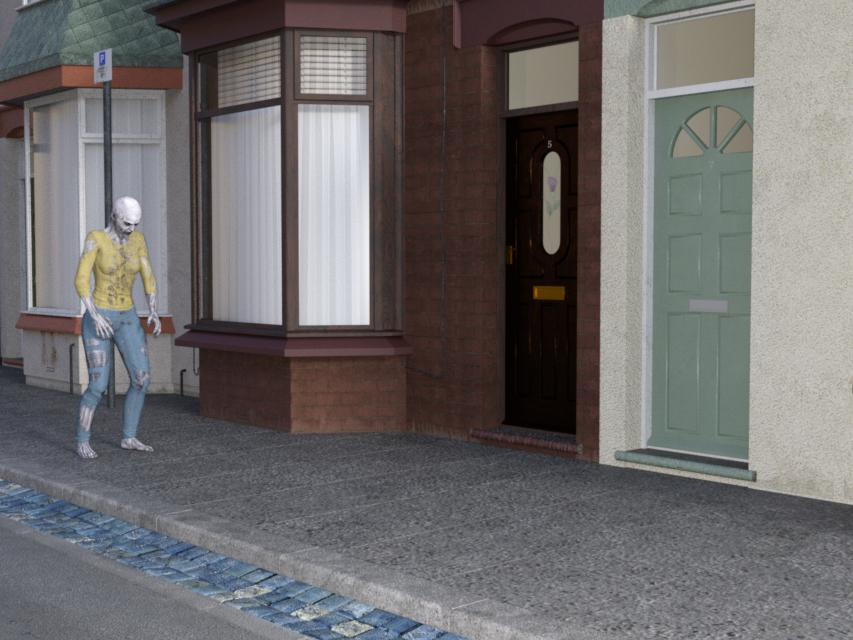


Frame 5


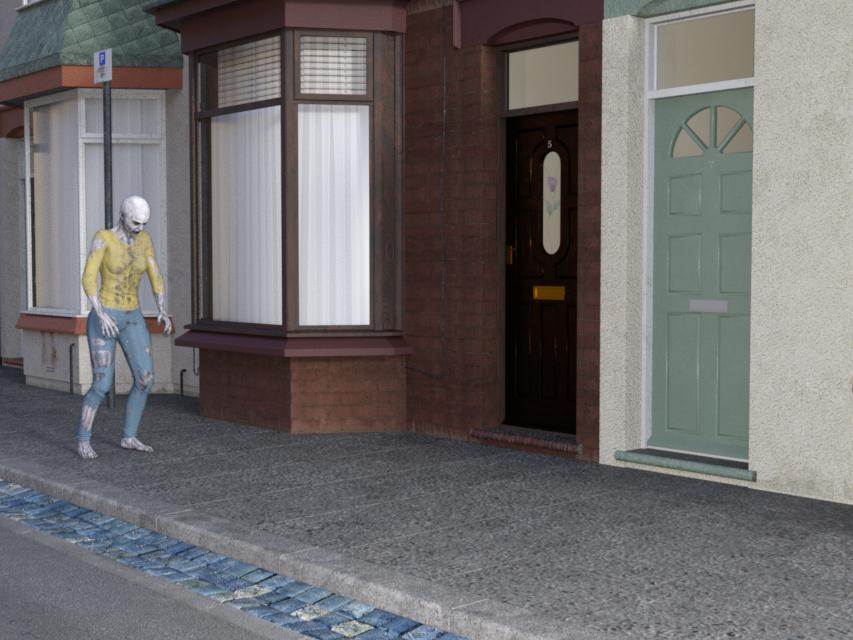


Frame 10


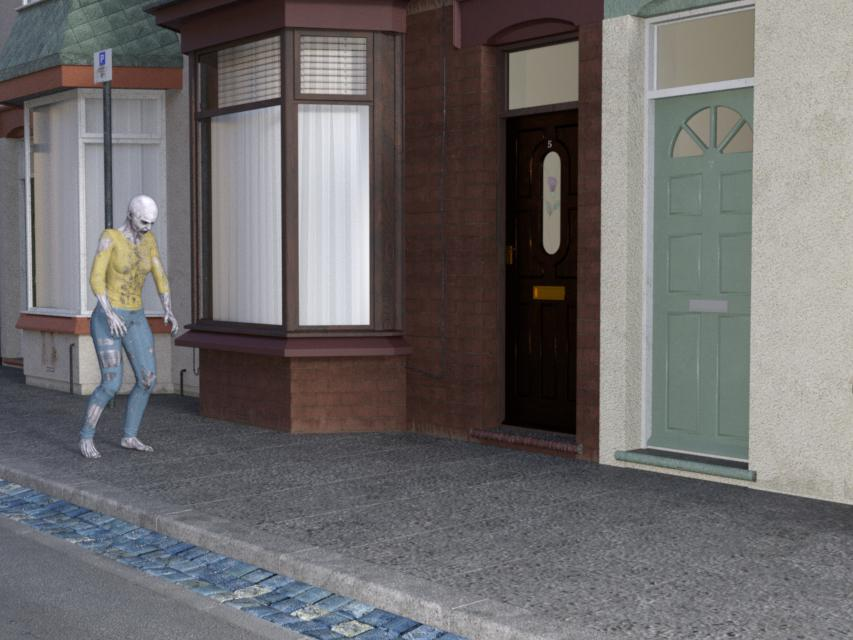

In [101]:
print('Frame 0')
display(IPyImage('./results/gif_frame_000.jpg'))
print()
print('Frame 5')
display(IPyImage('./results/gif_frame_005.jpg'))
print()
print('Frame 10')
display(IPyImage('./results/gif_frame_010.jpg'))

## Create a zip of the zombie-walk images. 
You can download this if you like to create your own animations

In [ ]:
zipf = zipfile.ZipFile('./zombie.zip', 'w', zipfile.ZIP_DEFLATED)

filenames = glob.glob('./results/gif_frame_*.jpg')
filenames = sorted(filenames)

for filename in filenames:
    zipf.write(filename)

zipf.close()

## Create Zombie animation

In [ ]:
imageio.plugins.freeimage.download()

!rm -rf ./results/zombie-anim.gif

anim_file = './zombie-anim.gif'

filenames = glob.glob('./results/gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []

for filename in filenames:
    image = imageio.imread(filename)
    images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=10)

Unfortunately, using `IPyImage` in the notebook (as you've done in the rubber ducky detection tutorial) for the large `gif` generated will disconnect the runtime. To view the animation, you can instead use the `Files` pane on the left and double-click on `zombie-anim.gif`. That will open a preview page on the right. It will take 2 to 3 minutes to load and see the walking zombie.

## Save results file for grading

Run the cell below to save your results. Download the `results.data` file and upload it to the grader in the classroom.

In [ ]:
import pickle

# remove file if it exists
!rm results.data

# write results to binary file. upload for grading.
with open('results.data', 'wb') as filehandle:
    pickle.dump(results['boxes'], filehandle)

print('Done saving! Please download `results.data` from the Files tab\n' \
      'on the left and submit for grading.\nYou can also use the next cell as a shortcut for downloading.')

In [ ]:
from google.colab import files

files.download('results.data')

**Congratulations on completing this assignment! Please go back to the Coursera classroom and upload `results.data` to the Graded Lab item for Week 2.**